In [61]:

# Ocean Wave Height and Period Forecasting with DeepAR
# Deep Autoregressive Time Series Modeling using PyTorch Forecasting

import warnings, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
import lightning as pl
import pytorch_forecasting as ptf
from pytorch_forecasting import TimeSeriesDataSet
from sktime.split import temporal_train_test_split
import importlib


from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils, config, mlflow_utils, training, plotting

importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)
importlib.reload(config)
importlib.reload(mlflow_utils)
importlib.reload(training)
importlib.reload(plotting)

from collections import namedtuple
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer, MultiNormalizer
from sktime.transformations.series.summarize import WindowSummarizer

from pytorch_forecasting import DeepAR
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import MultivariateNormalDistributionLoss
from pytorch_forecasting import MultiLoss, NormalDistributionLoss


from pytorch_forecasting.metrics import MAE, SMAPE

# Set random seeds for reproducibility
pl.seed_everything(config.RANDOM_STATE)
torch.manual_seed(config.RANDOM_STATE)
np.random.seed(config.RANDOM_STATE)


2025-07-28 00:38:51.597 | INFO     | oceanwave_forecast.config:<module>:12 - PROJ_ROOT path is: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast
Global seed set to 42


# 1. DATA PREPARATION AND PREPROCESSING


In [3]:
raw_path   = config.RAW_DATA_DIR / "Standard meteorological data 2024" / "46088h2024.txt"
df_raw     = data_manager.extract_raw_data(raw_path)
df_clean   = data_pipeline.preprocess_ocean_data(df_raw)
# df_clean   = df_clean.loc[config.START_DATE : config.END_DATE]

# split target & features
Y = df_clean[config.TARGETS]
X = df_clean.drop(columns=config.TARGETS)

y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=Y, X=X, test_size=config.HORIZON * 10
)


D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:111: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


# 2. FEATURE ENGINEERING FOR DEEPAR


In [4]:
pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

X_train_transformed = pipe_X.fit_transform(X_train)
X_test_transformed  = pipe_X.transform(X_test)
y_train_transformed = pipe_Y.fit_transform(y_train)
y_test_transformed  = pipe_Y.transform(y_test)


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [26]:
def _add_calendar(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    hr = df.index.hour
    df["month"] = df.index.month
    df["hour"] = hr
    df["hr_sin"] = np.sin(2 * np.pi * hr / 24)
    df["hr_cos"] = np.cos(2 * np.pi * hr / 24)
    return df


def make_long(
    X: pd.DataFrame,
    y: pd.DataFrame,
    series_col: str = config.ID_COLS[0],                #  identifier of each buoy / station
    time_col:  str = "timestamp"               #  DatetimeIndex will be copied here
) -> pd.DataFrame:
    # combine exogenous & targets side‑by‑side
    df = pd.concat([X, y], axis=1)

    df[time_col]   = df.index                  # DatetimeIndex → column
    df[series_col] = X.index.get_level_values(series_col) if isinstance(
        X.index, pd.MultiIndex
    ) else series_col                          # constant string if only one series

    # add calendar features
    df = _add_calendar(df)

    # Adding the time_idx (0,1,2,…) **within each group**
    df[config.ID_COLS[1]] = (
        df.groupby(series_col)[time_col]
          .rank(method="first")
          .astype("int64") - 1
    )
    df = df.drop(columns=[time_col])  # drop the original DatetimeIndex

    return df.reset_index(drop=True)


train_long = make_long(X_train_transformed, y_train_transformed)
test_long  = make_long(X_test_transformed,  y_test_transformed)

print("TRAIN head:\n", train_long.head(3))
print("TEST  head:\n", test_long.head(3))
print("TRAIN shape:\n", train_long.shape)
print("TEST  shape:\n", test_long.shape)

TRAIN head:
        WSPD       GST      PRES      ATMP      WTMP      DEWP  WDIR_sin  \
0 -0.945944 -0.877987  0.973289 -0.763690 -0.601870 -0.572855  1.712621   
1 -1.204516 -1.147758  1.014906 -0.810166 -0.631785 -0.572855  1.633114   
2 -1.431427 -1.327605  1.040339 -0.856642 -0.661700 -0.572855  0.121828   

   WDIR_cos   MWD_sin   MWD_cos      WVHT       APD  group_id  month  hour  \
0  0.050028  1.967362  1.453692 -0.767869  0.790348  group_id      1     0   
1  0.015358  1.967362  1.453692 -0.706999  1.472553  group_id      1     1   
2  0.756579  1.967336  1.453692 -0.783087  1.503329  group_id      1     2   

     hr_sin    hr_cos  time_idx  
0  0.000000  1.000000         0  
1  0.258819  0.965926         1  
2  0.500000  0.866025         2  
TEST  head:
        WSPD       GST      PRES      ATMP      WTMP      DEWP  WDIR_sin  \
0 -0.170226 -0.308471  1.151319 -0.577787 -0.586912 -0.523410  0.351806   
1 -0.212442 -0.364138  1.162880 -0.548739 -0.601870 -0.523410  0.616580   

In [27]:

def apply_window_summarizer(
    df,
    summarizer: WindowSummarizer,
    target_cols: list[str],
    fit: bool = True
):
    # Get the target columns from the DataFrame
    df_targets = df[target_cols]
    
    # Apply the summarizer
    if fit:
        df_lagged = summarizer.fit_transform(df_targets)
    else:
        df_lagged = summarizer.transform(df_targets)
    
    # Re-join the new features
    return df.join(df_lagged)



# Configure window summarizer
summarizer = WindowSummarizer(
    lag_feature=config.TARGET_WINDOWSUMMARY_CONFIG,
    target_cols=config.TARGETS,
    n_jobs=1,
)

train_long = apply_window_summarizer(
    train_long,
    summarizer,
    config.TARGETS,
    fit=True
)

test_long = apply_window_summarizer(
    test_long,
    summarizer,
    config.TARGETS,
    fit=False
)

print("TRAIN head:\n", train_long.head(3))
print("TEST  head:\n", test_long.head(3))
print("TRAIN shape:\n", train_long.shape)
print("TEST  shape:\n", test_long.shape)


TRAIN head:
        WSPD       GST      PRES      ATMP      WTMP      DEWP  WDIR_sin  \
0 -0.945944 -0.877987  0.973289 -0.763690 -0.601870 -0.572855  1.712621   
1 -1.204516 -1.147758  1.014906 -0.810166 -0.631785 -0.572855  1.633114   
2 -1.431427 -1.327605  1.040339 -0.856642 -0.661700 -0.572855  0.121828   

   WDIR_cos   MWD_sin   MWD_cos  ...  WVHT_mean_24_48  APD_lag_1 APD_lag_2  \
0  0.050028  1.967362  1.453692  ...              NaN        NaN       NaN   
1  0.015358  1.967362  1.453692  ...              NaN   0.790348       NaN   
2  0.756579  1.967336  1.453692  ...              NaN   1.472553  0.790348   

   APD_lag_3  APD_lag_4  APD_lag_24  APD_lag_48  APD_lag_72  APD_mean_1_24  \
0        NaN        NaN         NaN         NaN         NaN            NaN   
1        NaN        NaN         NaN         NaN         NaN            NaN   
2        NaN        NaN         NaN         NaN         NaN            NaN   

   APD_mean_24_48  
0             NaN  
1             NaN  


In [28]:
print(train_long.dtypes.to_frame(name="Data Type"))


                Data Type
WSPD              float64
GST               float64
PRES              float64
ATMP              float64
WTMP              float64
DEWP              float64
WDIR_sin          float64
WDIR_cos          float64
MWD_sin           float64
MWD_cos           float64
WVHT              float64
APD               float64
group_id           object
month               int32
hour                int32
hr_sin            float64
hr_cos            float64
time_idx            int64
WVHT_lag_1        float64
WVHT_lag_2        float64
WVHT_lag_3        float64
WVHT_lag_4        float64
WVHT_lag_24       float64
WVHT_lag_48       float64
WVHT_lag_72       float64
WVHT_mean_1_24    float64
WVHT_mean_24_48   float64
APD_lag_1         float64
APD_lag_2         float64
APD_lag_3         float64
APD_lag_4         float64
APD_lag_24        float64
APD_lag_48        float64
APD_lag_72        float64
APD_mean_1_24     float64
APD_mean_24_48    float64


In [29]:

# build the exclude list
exclude = set(config.TARGETS + config.ID_COLS)

# all other columns become covariates
covariate_variables = [col for col in train_long.columns if col not in exclude]

print("Covariates:", covariate_variables)

Covariates: ['WSPD', 'GST', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'WDIR_sin', 'WDIR_cos', 'MWD_sin', 'MWD_cos', 'month', 'hour', 'hr_sin', 'hr_cos', 'WVHT_lag_1', 'WVHT_lag_2', 'WVHT_lag_3', 'WVHT_lag_4', 'WVHT_lag_24', 'WVHT_lag_48', 'WVHT_lag_72', 'WVHT_mean_1_24', 'WVHT_mean_24_48', 'APD_lag_1', 'APD_lag_2', 'APD_lag_3', 'APD_lag_4', 'APD_lag_24', 'APD_lag_48', 'APD_lag_72', 'APD_mean_1_24', 'APD_mean_24_48']


In [30]:
train_long_clean = train_long.dropna(subset=covariate_variables).reset_index(drop=True)
test_long_clean  = test_long.dropna(subset=covariate_variables).reset_index(drop=True)

# 3. TIMESERIESDATASET CONFIGURATION


In [56]:
config.TARGETS

['WVHT', 'APD']

In [31]:
# 4. build the training TimeSeriesDataSet
train_ds = TimeSeriesDataSet(
    data=train_long_clean,
    time_idx=config.ID_COLS[1],
    target=config.TARGETS,
    group_ids=[config.ID_COLS[0]], 
    max_encoder_length=config.WINDOW,
    max_prediction_length=config.HORIZON,
    static_reals=None,
    time_varying_known_categoricals=None,
    time_varying_known_reals=covariate_variables,
    time_varying_unknown_categoricals=None,
    time_varying_unknown_reals=config.TARGETS,
    target_normalizer=MultiNormalizer(
        [GroupNormalizer(groups=[config.ID_COLS[0]]) for _ in config.TARGETS]
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

test_ds = TimeSeriesDataSet.from_dataset(
    train_ds, 
    test_long_clean, 
    stop_randomization=True
)



In [32]:
train_loader = train_ds.to_dataloader(train=True, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)
test_loader = test_ds.to_dataloader(train=False, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)

In [33]:
plotting.plot_dataloader_sample(train_loader, config.TESTING_REPORTS_DIR / "Testing_data_sample.png")

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\plotting.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Sample batch data visualization saved to D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\testing\Testing_data_sample.png


# 4. TRAINING


In [ ]:

# Setup callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=config.EARLY_STOP_PATIENCE, 
    min_delta=config.EARLY_STOP_MIN_DELTA,
    verbose=False, 
    mode="min"
)
lr_logger = LearningRateMonitor(logging_interval="epoch")
print_metrics_callback = training.PrintMetricsCallback(print_every_n_epochs=10)

# Setup trainer
trainer = Trainer(
    max_epochs=config.MAX_EPOCHS,
    accelerator="auto",
    gradient_clip_val=config.GRADIENT_CLIP_VAL,
    callbacks=[lr_logger, early_stop_callback, print_metrics_callback],
    limit_train_batches=config.LIMIT_TRAIN_BATCHES,
    val_check_interval=config.VAL_CHECK_INTERVAL,
    log_every_n_steps=config.LOG_EVERY_N_STEPS,
    enable_progress_bar=True
)

multivar_loss = MultiLoss(
    [NormalDistributionLoss(), NormalDistributionLoss()]  # One loss per target
)

model = DeepAR.from_dataset(
    train_ds,
    learning_rate=config.LEARNING_RATE,
    hidden_size=config.DEEPAR_CONFIG["lstm_hidden_dim"],
    rnn_layers=config.DEEPAR_CONFIG["lstm_layers"],
    dropout=config.DEEPAR_CONFIG["lstm_dropout"],
    optimizer=config.OPTIMIZER,
    loss=multivar_loss,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
trainer.fit(model, train_loader, test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type           | Params
----------------------------------------------------------
0 | loss                   | MultiLoss      | 0     
1 | logging_metrics        | ModuleList     | 0     
2 | embeddings             | MultiEmbedding | 0     
3 | rnn                    | LSTM           | 351 K 
4 | distribution_projector | ModuleList     | 516   
----------------------------------------------------------
351 K     Trainable params
0         Non-trainable params
351 K     Total params
1.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Epoch 0 Summary:
------------------------------


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch 0 Summary:
  -> Validation Loss: 2.4937
------------------------------


Validation: 0it [00:00, ?it/s]


Epoch 0 Summary:
  -> Validation Loss: 1.6841
------------------------------


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch 10 Summary:
  -> Train Loss: -0.6771
  -> Validation Loss: 0.6504
------------------------------


Validation: 0it [00:00, ?it/s]


Epoch 10 Summary:
  -> Train Loss: -0.6771
  -> Validation Loss: 0.6619
------------------------------


# 5. MODEL EVALUATION

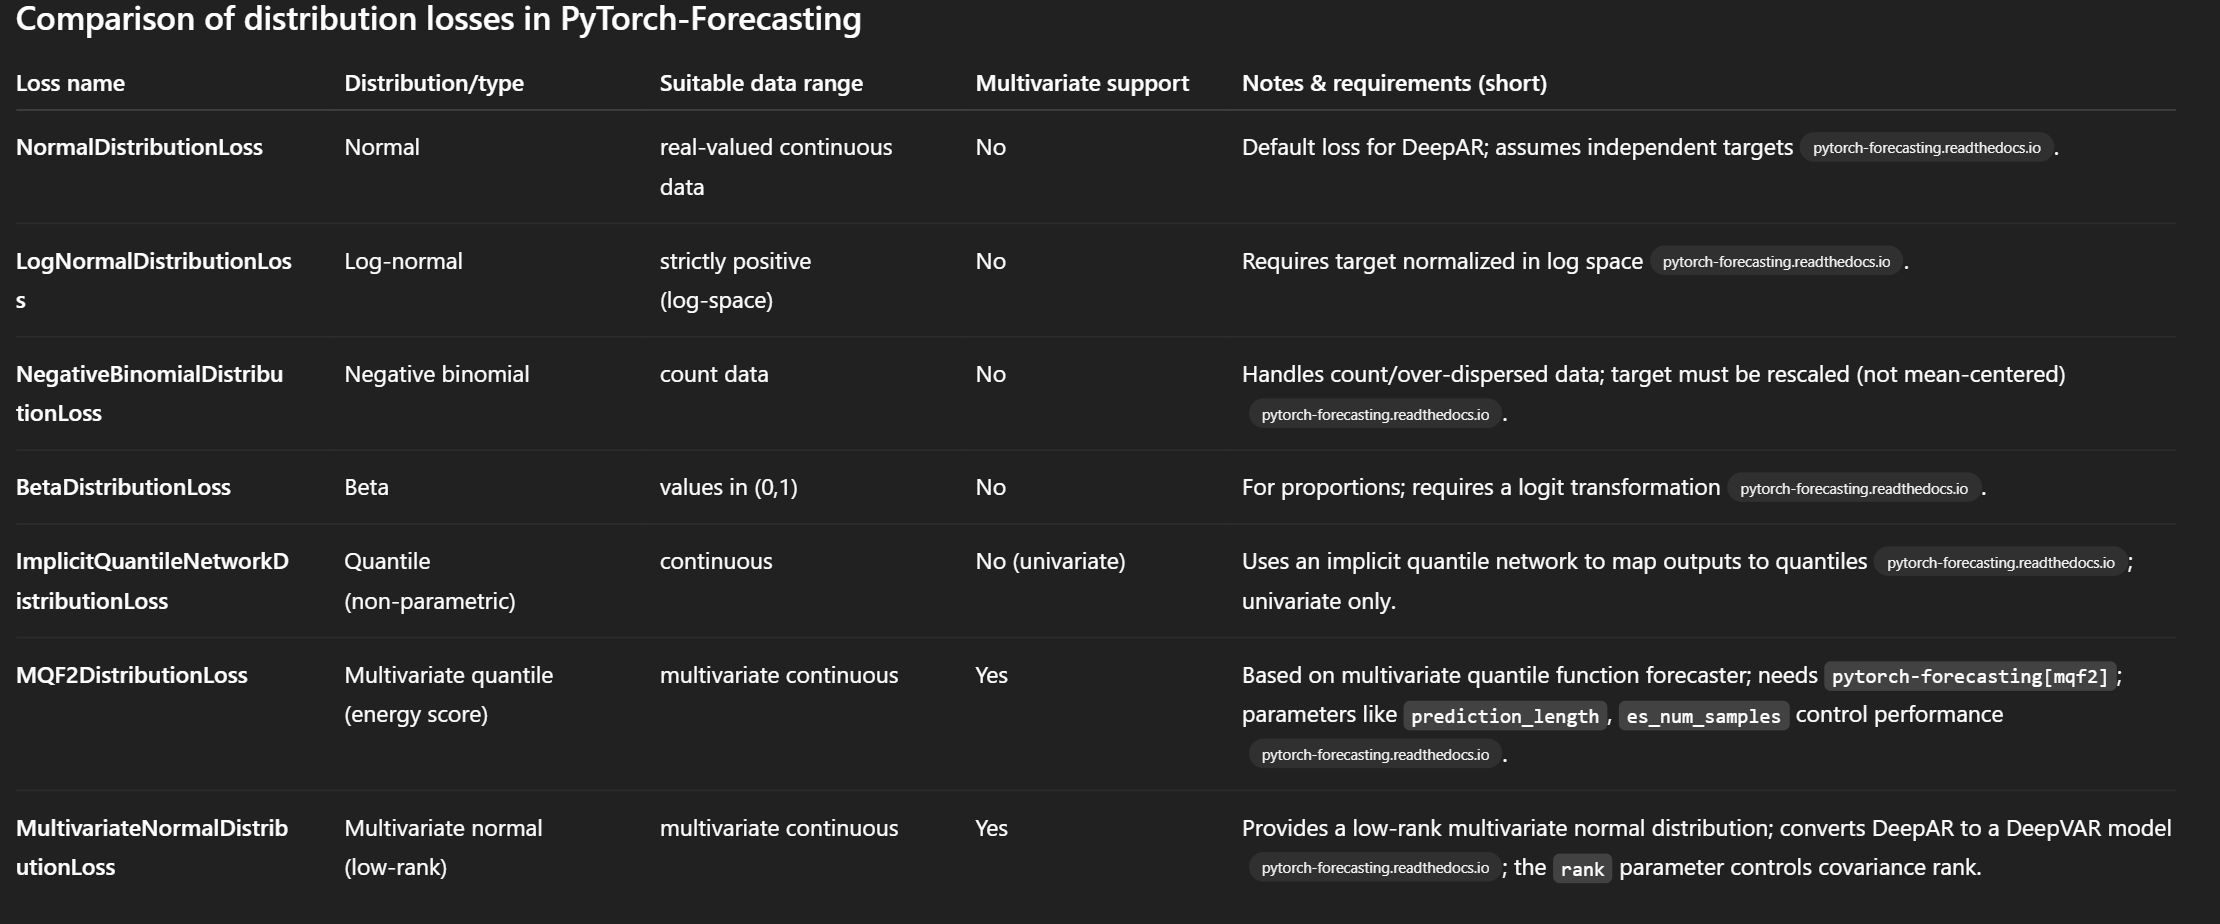

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)
    



c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` an

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 9 for tensor number 1 in the list.

In [71]:
predictions = best_model.predict(
        test_loader, 
        trainer_kwargs=dict(accelerator="auto"),
        batch_size=1,
        return_y=False
    )
    
    # Get ground truth manually
y_true_list = []
for batch in test_loader:
        y_true_list.append(batch[1])  # target values
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [81]:
pred = best_model.predict(
        test_loader,
        return_y=True,               # gives you ground‑truth
        trainer_kwargs=dict(accelerator="cpu")   # avoid GPU ↔ CPU copy for metrics
)

y_hat, y_true = pred.output, pred.y          # shapes: [batch, horizon, n_targets]


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 9 for tensor number 1 in the list.

In [ ]:
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, MAPE

target_names = config.TARGETS  # ['WVHT', 'APD']
metrics = {
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'SMAPE': SMAPE(),
    'MAPE': MAPE()
}

print("\nMETRICS BY TARGET:")
print("-" * 40)
for i, target_name in enumerate(target_names):
    print(f"\n{target_name.upper()}:")
    for metric_name, metric_fn in metrics.items():
        if predictions.output.dim() > 2:  # Multi-target case
            target_pred = predictions.output[:, :, i]
            target_true = predictions.y[:, :, i]
        else:
            target_pred = predictions.output
            target_true = predictions.y
        
        score = metric_fn(target_pred, target_true)
        print(f"  {metric_name}: {score:.4f}")

# Overall metrics (averaged across targets)
print(f"\nOVERALL METRICS (averaged):")
for metric_name, metric_fn in metrics.items():
    score = metric_fn(predictions.output, predictions.y)
    print(f"  {metric_name}: {score:.4f}")